In [40]:
import torch
from torchvision import transforms
import os

from utils.preprocess_image import preprocess_image
from utils.process_image import generate_latent_image, decompress_latent, generate_y_strings, get_no_strings_time, generate_compressed_image, save_ref_image
from utils.load_checkpoints import load_checkpoints
from utils.metric_calculation import calculate_psnr, calculate_lpips, calculate_bpp

from PIL import Image
from diffusers.models import AutoencoderKL
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics import PeakSignalNoiseRatio
from pillow_heif import register_heif_opener, register_avif_opener

#model setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
psnr_model = PeakSignalNoiseRatio().to(device)
lpips_model = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)

# Paths
images_path = '../kodak'
output_path = './outputs/sweep_all'
checkpoints_dir = '../checkpoints'
TCM_checkpoints_dir = '../LIC_TCM/checkpoints'

def create_latents(images_path, output_path, ae):
    ae_images = {}
    for image_name_bmp in os.listdir(images_path):
        
        image, image_name = preprocess_image(images_path, image_name_bmp, output_path)
        if image is None or image_name is None:
            continue 
        img_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
        with torch.no_grad():
            img_latent, encode_time = generate_latent_image(img_tensor, os.path.join(output_path, f'{image_name}_ae_latent.pt'), ae, save_encode_time=True)
            ae_decompressed_image, decode_time = decompress_latent(img_latent, os.path.join(output_path, f'{image_name}_ae_decomp.png'), ae, save_decode_time=True)

            ae_images[image_name] = {}
            ae_images[image_name]['encode_time'] = encode_time
            ae_images[image_name]['decode_time'] = decode_time
            ae_images[image_name]['image'] = image 
            ae_images[image_name]['image_size'] = image.size[0] * image.size[1]
            ae_images[image_name]['decomp_img'] = ae_decompressed_image
            ae_images[image_name]['latent'] = img_latent

    return ae_images


ae_images = create_latents(images_path, output_path, ae)

/home/ai1/liveCompress/venv2/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/ai1/liveCompress/venv2/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted

Processing image: kodim09.png
Processing image: kodim15.png
Processing image: kodim23.png
Processing image: kodim19.png
Processing image: kodim12.png
Processing image: kodim01.png
Processing image: kodim17.png
Processing image: kodim22.png
Processing image: kodim05.png
Processing image: kodim08.png
Processing image: kodim03.png
Processing image: kodim02.png
Processing image: kodim13.png
Processing image: kodim07.png
Processing image: kodim16.png
Processing image: kodim21.png
Processing image: kodim10.png
Processing image: kodim11.png
Processing image: kodim24.png
Processing image: kodim04.png
Processing image: kodim18.png
Processing image: kodim20.png


NOTE: before continuing, please run the following command to generate the metrics file necessary for comparisons with other neural-network models (bmshj, cheng, tcm, mlic):
```
cd testing && sh run_all_nn_tests.sh
```


In [41]:

import time

register_heif_opener()
register_avif_opener()

image_types = ['webp', 'jpeg', 'heif', 'avif'] 

image_quality = [10,20, 25,35,45,55,65,80,90]

compressai_qualities = ["1", "2", "3", "4", "5", "6"]

TCM_lambdas = ["0.0025", "0.0035", "0.0067", "0.013", "0.025", "0.05"]

vtm_qualities = ['39', '36', '33', '30', '27']

#calculate metrics for reference image types and qualities
metrics = {}
for image_type in image_types:
    metrics[image_type] = {}
    for quality in image_quality:
        metrics[image_type][quality] = []
        for image_name, image_data in ae_images.items():
            #first does the compression and decompression from and to the latent, to measure the time
            start_time = time.time()
            save_ref_image(quality, f'qual_{quality}.{image_type}', image_data['decomp_img'], output_path, image_name)
            compression_time = time.time() - start_time

            start_time = time.time()
            decomp_img = Image.open(os.path.join(output_path, f'{image_name}_qual_{quality}.{image_type}'))
            decompression_time = time.time() - start_time
           
            metrics[image_type][quality].append({
                'image_name': image_name,
                'bpp': calculate_bpp(os.path.join(output_path, f'{image_name}_qual_{quality}.{image_type}'), ae_images[image_name]['image_size']),
                'psnr': calculate_psnr(ae_images[image_name]['decomp_img'], decomp_img),
                'lpips': calculate_lpips(ae_images[image_name]['decomp_img'], decomp_img),
                'compression_time': compression_time,
                'decompression_time': decompression_time
            })

In [42]:
#obtain metrics for neural networks from json files
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import json

# Load metrics from JSON file
with open('nn_metrics/cheng_results.json', 'r') as f:
    cheng_metrics = json.load(f)
with open('nn_metrics/mlic_results.json', 'r') as f:
    mlic_metrics = json.load(f)
with open('nn_metrics/tcm_results.json', 'r') as f:
    tcm_metrics = json.load(f) 
with open('nn_metrics/bmshj_results.json', 'r') as f:
    bmshj_metrics = json.load(f)
with open('nn_metrics/vtm_results.json', 'r') as f:
    vtm_metrics = json.load(f)

metrics['cheng'] = cheng_metrics
metrics['bmshj'] = bmshj_metrics
metrics['tcm'] = tcm_metrics
metrics['mlic'] = mlic_metrics
metrics['vtm'] = vtm_metrics

print(metrics)

{'webp': {10: [{'image_name': 'kodim09', 'bpp': 0.1629638671875, 'psnr': 31.370752334594727, 'lpips': 0.3605099320411682, 'compression_time': 0.026123523712158203, 'decompression_time': 0.0006480216979980469}, {'image_name': 'kodim15', 'bpp': 0.1536865234375, 'psnr': 30.426790237426758, 'lpips': 0.3402123749256134, 'compression_time': 0.024265289306640625, 'decompression_time': 0.0004761219024658203}, {'image_name': 'kodim23', 'bpp': 0.15205891927083334, 'psnr': 31.608570098876953, 'lpips': 0.31557697057724, 'compression_time': 0.024166584014892578, 'decompression_time': 0.0009927749633789062}, {'image_name': 'kodim19', 'bpp': 0.2274169921875, 'psnr': 29.577804565429688, 'lpips': 0.3793468773365021, 'compression_time': 0.02642989158630371, 'decompression_time': 0.00033783912658691406}, {'image_name': 'kodim12', 'bpp': 0.13232421875, 'psnr': 31.45282554626465, 'lpips': 0.3886992931365967, 'compression_time': 0.024306535720825195, 'decompression_time': 0.0009374618530273438}, {'image_nam

In [43]:
lambda_vals = ["1e-3", "2e-3", "3e-3", "5e-4", "7e-4"]

from model.model import liveModel

net = liveModel(N=24, M=36).to(device)

#calculate metrics for our trained model
metrics['live'] = {}
for lambda_val in lambda_vals:
    metrics['live'][lambda_val] = []
    net = liveModel(N=24,M=36).to(device)
    checkpoint = "checkpoint_"+lambda_val+"_best_loss.pth.tar"
    checkpoint_path = os.path.join(checkpoints_dir, checkpoint)
    print(checkpoint_path)
    
    load_checkpoints(checkpoint_path, net, device)
    net.update()
    
    with torch.no_grad():
        for image_name, image_data in ae_images.items():
            y_strings_path = os.path.join(output_path, f'{image_name}_y_strings.pt')
            y_strings, compressed_output, compression_time = generate_y_strings(image_data['latent'], y_strings_path, net, save_y_strings_time=True)
            no_strings_time = get_no_strings_time(image_data['latent'], net)
            compressed_image, decompression_time= generate_compressed_image(y_strings, compressed_output, os.path.join(output_path, f'{image_name}_{lambda_val}_compressed.png'), net, ae, save_decompress_time=True)
            item = {
                'image_name': image_name,
                'bpp': calculate_bpp(y_strings_path, image_data['image_size']),
                'psnr': calculate_psnr(image_data['decomp_img'], compressed_image),
                'lpips': calculate_lpips(image_data['decomp_img'], compressed_image),
                'compression_time': compression_time,
                'decompression_time': decompression_time,
                'no_strings_time': no_strings_time
            }
            metrics['live'][lambda_val].append(item)  
        

../checkpoints/checkpoint_1e-3_best_loss.pth.tar


/home/ai1/liveCompress/testing/utils/load_checkpoints.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


../checkpoints/checkpoint_2e-3_best_loss.pth.tar
../checkpoints/checkpoint_3e-3_best_loss.pth.tar
../checkpoints/checkpoint_5e-4_best_loss.pth.tar
../checkpoints/checkpoint_7e-4_best_loss.pth.tar


In [44]:
#define utility functions to initialize and calculate average metrics
def calculate_average_ae_times(ae_images):
    """Calculate average encode and decode times for autoencoder images."""
    count = len(ae_images)
    if (not ae_images or count == 0):
        return 0, 0
        
    total_encode = sum(data['encode_time'] for data in ae_images.values())
    total_decode = sum(data['decode_time'] for data in ae_images.values())
    
    
    return total_encode / count, total_decode / count

def aggregate_metrics(count, metrics, metric_type):
    """Convert raw metric lists into averages."""
    return sum(item[metric_type] for item in metrics) / count if count > 0 else 0


def initialize_metrics_dict(formats, qualities):
    return {metric: {fmt: {q: 0 for q in qualities[fmt]} for fmt in formats}
            for metric in ['bpp', 'psnr', 'lpips', 'compression_time', 'decompression_time']}

def calculate_format_averages(metrics_data, format_type, qualities, metrics_dict):
    for quality in qualities:
        print(quality)
        print(format_type)
        metrics_list = metrics_data[format_type][quality]
        count = len(metrics_list)
        for metric in ['bpp', 'psnr', 'lpips', 'compression_time', 'decompression_time']:
            metrics_dict[metric][format_type][quality] = aggregate_metrics(count, metrics_list, metric)
    return metrics_dict

def print_format_averages(metrics_dict, format_type, qualities):
    print(f"\nSummary of average metrics for '{format_type}':")
    for quality in qualities:
        print(f"Quality: {quality}")
        for metric in ['bpp', 'psnr', 'lpips', 'compression_time', 'decompression_time']:
            value = metrics_dict[metric][format_type][quality]
            print(f"  Average {metric.upper()}: {value:.4f}")

In [45]:
# Calculate average encode/decode times for ae_images
average_encode_time, average_decode_time = calculate_average_ae_times(ae_images)
print(f"Average Encode Time: {average_encode_time}")
print(f"Average Decode Time: {average_decode_time}")

# Initialize qualities
qualities_map = {
    **{img_type: image_quality for img_type in image_types},  # Traditional formats
    'live': lambda_vals,                                      # Live format
    'bmshj': compressai_qualities,                           # CompressAI formats
    'cheng': compressai_qualities,
    'tcm': TCM_lambdas,
    'mlic': compressai_qualities,
    'vtm': vtm_qualities
}

average_metrics = initialize_metrics_dict(list(qualities_map.keys()), qualities_map)

# Calculate averages for traditional formats
for img_type in image_types:
    average_metrics = calculate_format_averages(metrics, img_type, qualities_map[img_type], average_metrics)
    print_format_averages(average_metrics, img_type, qualities_map[img_type])

# Live compression metrics
average_metrics['no_strings_time'] = {'live': {lambda_val: 0 for lambda_val in lambda_vals}}
average_metrics = calculate_format_averages(metrics, 'live', lambda_vals, average_metrics)

# Calculate no_strings_time separately for live format
for lambda_val in lambda_vals:
    count = len(metrics['live'][lambda_val])
    average_metrics['no_strings_time']['live'][lambda_val] = aggregate_metrics(
        count, metrics['live'][lambda_val], 'no_strings_time'
    )
print_format_averages(average_metrics, 'live', lambda_vals)

# CompressAI formats (bmshj and cheng), as well as mlic (it uses the same qualities)
for format_type in ['bmshj', 'cheng', 'mlic']:
    average_metrics = calculate_format_averages(metrics, format_type, compressai_qualities, average_metrics)
    print_format_averages(average_metrics, format_type, compressai_qualities)

# other NN models
average_metrics = calculate_format_averages(metrics, 'tcm', TCM_lambdas, average_metrics)
print_format_averages(average_metrics, 'tcm', TCM_lambdas)
average_metrics = calculate_format_averages(metrics, 'vtm', vtm_qualities, average_metrics)
print_format_averages(average_metrics, 'vtm', vtm_qualities)


Average Encode Time: 0.005038759925148704
Average Decode Time: 0.005956801501187411
10
webp
20
webp
25
webp
35
webp
45
webp
55
webp
65
webp
80
webp
90
webp

Summary of average metrics for 'webp':
Quality: 10
  Average BPP: 0.2456
  Average PSNR: 29.7502
  Average LPIPS: 0.3269
  Average COMPRESSION_TIME: 0.0265
  Average DECOMPRESSION_TIME: 0.0006
Quality: 20
  Average BPP: 0.3370
  Average PSNR: 30.8893
  Average LPIPS: 0.2779
  Average COMPRESSION_TIME: 0.0279
  Average DECOMPRESSION_TIME: 0.0006
Quality: 25
  Average BPP: 0.3817
  Average PSNR: 31.3564
  Average LPIPS: 0.2590
  Average COMPRESSION_TIME: 0.0285
  Average DECOMPRESSION_TIME: 0.0005
Quality: 35
  Average BPP: 0.4736
  Average PSNR: 32.2586
  Average LPIPS: 0.2260
  Average COMPRESSION_TIME: 0.0300
  Average DECOMPRESSION_TIME: 0.0006
Quality: 45
  Average BPP: 0.5638
  Average PSNR: 33.0852
  Average LPIPS: 0.2008
  Average COMPRESSION_TIME: 0.0310
  Average DECOMPRESSION_TIME: 0.0006
Quality: 55
  Average BPP: 0.6501


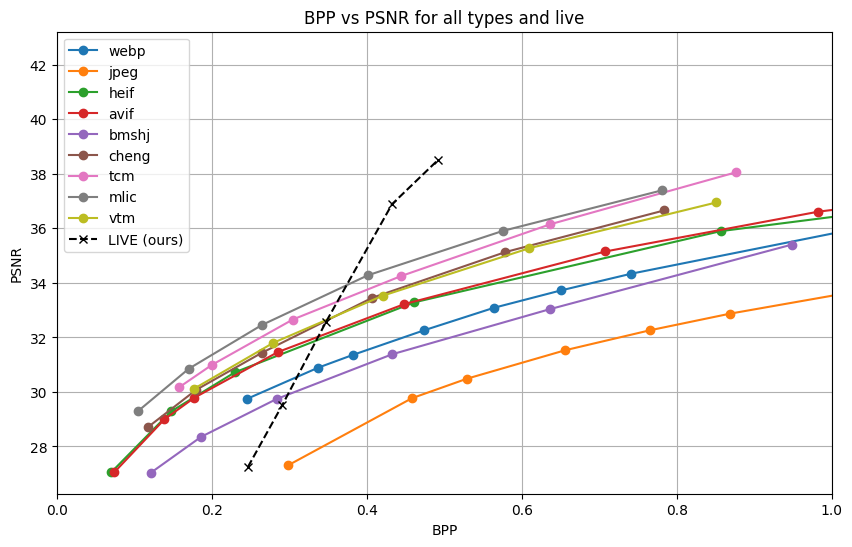

In [46]:
# Plot BPP vs PSNR for all types
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

#add traditional formats to the plot
for image_type in image_types:
    bpp_values = []
    psnr_values = []
    for quality in image_quality:
        bpp_values.append(average_metrics['bpp'][image_type][quality])
        psnr_values.append(average_metrics['psnr'][image_type][quality])
    
    plt.plot(bpp_values, psnr_values, marker='o', label=image_type)

# Plot each CompressAI and other NN model
for model_key in ['bmshj', 'cheng', 'tcm', 'mlic', 'vtm']:
    if model_key in metrics:  # Only plot models that have metrics
        bpp_values = []
        psnr_values = []
        if model_key != 'tcm' and model_key != 'vtm':
            for quality in compressai_qualities:
                bpp_values.append(average_metrics['bpp'][model_key][quality])
                psnr_values.append(average_metrics['psnr'][model_key][quality])
        elif model_key == 'tcm':
            for quality in TCM_lambdas:
                bpp_values.append(average_metrics['bpp'][model_key][quality])
                psnr_values.append(average_metrics['psnr'][model_key][quality])
        elif model_key == 'vtm':
            for quality in vtm_qualities:
                bpp_values.append(average_metrics['bpp'][model_key][quality])
                psnr_values.append(average_metrics['psnr'][model_key][quality])
        else:
            continue
        
        # Sort by bpp for better curve visualization
        sorted_metrics = sorted(zip(bpp_values, psnr_values), key=lambda x: x[0])
        bpp_values_sorted, psnr_values_sorted = zip(*sorted_metrics)
        
        plt.plot(bpp_values_sorted, psnr_values_sorted, 
                linestyle='solid', 
                label=f'{model_key}',
                marker = 'o')


# Add 'live' type to the plot
bpp_values_live = [average_metrics['bpp']['live'][lambda_val] for lambda_val in lambda_vals]
psnr_values_live = [average_metrics['psnr']['live'][lambda_val] for lambda_val in lambda_vals]

# Sort the live values by bpp
sorted_live_metrics = sorted(zip(bpp_values_live, psnr_values_live), key=lambda x: x[0])
bpp_values_live_sorted, psnr_values_live_sorted = zip(*sorted_live_metrics)

plt.plot(bpp_values_live_sorted, psnr_values_live_sorted, marker='x', linestyle='--', color='black', label='LIVE (ours)')
plt.xlim(0, 1) 
plt.xlabel('BPP')
plt.ylabel('PSNR')
plt.title('BPP vs PSNR for all types and live')
plt.legend()
plt.grid(True)
plt.show()


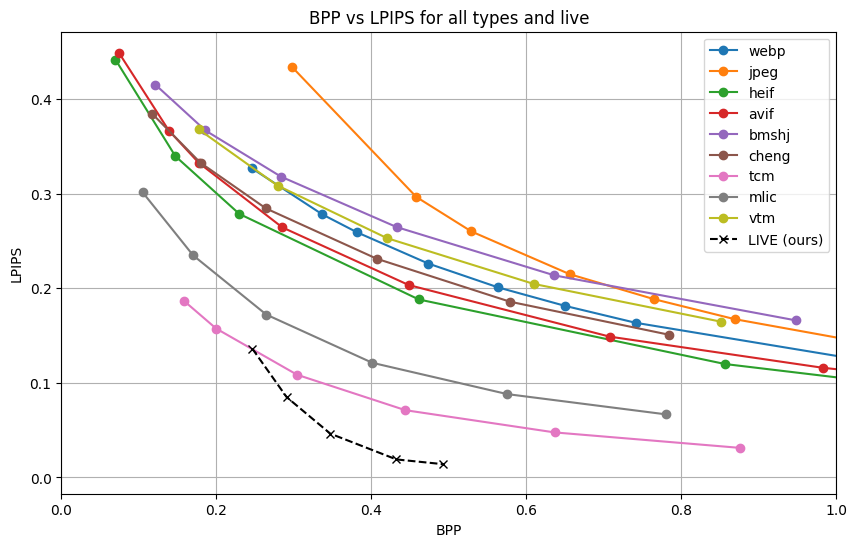

In [47]:
# Plot BPP vs LPIPS for all types and 'live'
plt.figure(figsize=(10, 6))

for image_type in image_types:
    bpp_values = []
    lpips_values = []
    for quality in image_quality:
        bpp_values.append(average_metrics['bpp'][image_type][quality])
        lpips_values.append(average_metrics['lpips'][image_type][quality])
    
    plt.plot(bpp_values, lpips_values, marker='o', label=image_type)

# Plot each CompressAI and other NN model
for model_key in ['bmshj', 'cheng', 'tcm', 'mlic', 'vtm']:
    if model_key in metrics:  # Only plot models that have metrics
        bpp_values = []
        lpips_values = []
        if model_key != 'tcm' and model_key != 'vtm':
            for quality in compressai_qualities:
                bpp_values.append(average_metrics['bpp'][model_key][quality])
                lpips_values.append(average_metrics['lpips'][model_key][quality])
        elif model_key == 'tcm':
            for quality in TCM_lambdas:
                bpp_values.append(average_metrics['bpp'][model_key][quality])
                lpips_values.append(average_metrics['lpips'][model_key][quality])
        elif model_key == 'vtm':
            for quality in vtm_qualities:
                bpp_values.append(average_metrics['bpp'][model_key][quality])
                lpips_values.append(average_metrics['lpips'][model_key][quality])
        else:
            continue
        
        # Sort by bpp for better curve visualization
        sorted_metrics = sorted(zip(bpp_values, lpips_values), key=lambda x: x[0])
        bpp_values_sorted, lpips_values_sorted = zip(*sorted_metrics)
        
        plt.plot(bpp_values_sorted, lpips_values_sorted, 
                marker='o', 
                linestyle='solid', 
                label=f'{model_key}')

# Add 'live' type to the plot
bpp_values_live = [average_metrics['bpp']['live'][lambda_val] for lambda_val in lambda_vals]
lpips_values_live = [average_metrics['lpips']['live'][lambda_val] for lambda_val in lambda_vals]

# Sort the live values by bpp
sorted_live_metrics = sorted(zip(bpp_values_live, lpips_values_live), key=lambda x: x[0])
bpp_values_live_sorted, lpips_values_live_sorted = zip(*sorted_live_metrics)

plt.plot(bpp_values_live_sorted, lpips_values_live_sorted, marker='x', linestyle='--', color='black', label='LIVE (ours)')
plt.xlim(0, 1) 
plt.xlabel('BPP')
plt.ylabel('LPIPS')
plt.title('BPP vs LPIPS for all types and live')
plt.legend()
plt.grid(True)
plt.show()


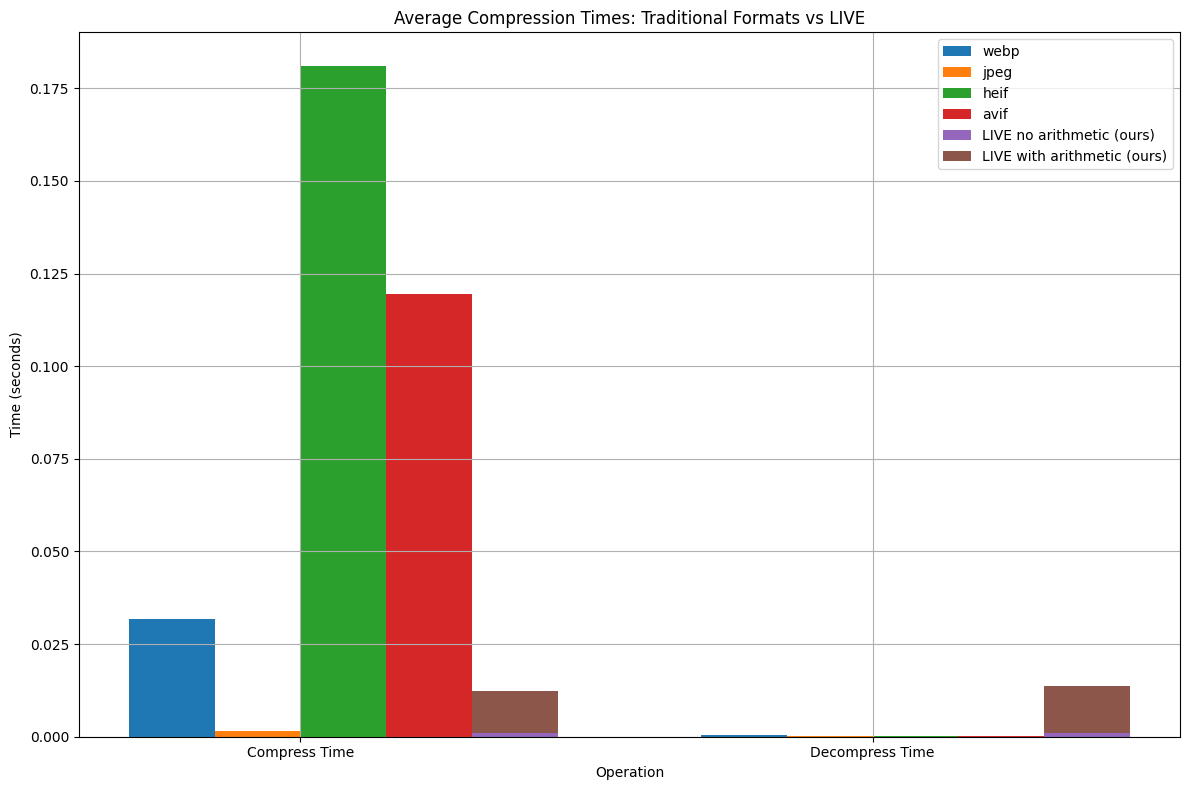

In [48]:
# Part 1: Compare LIVE with traditional image types
import numpy as np

#store all average compression times for both traditional and neural network models for psnr vs compression time plot later
all_avg_compress_times = []

# Calculate averages for traditional formats
compress_times = {image_type: [] for image_type in image_types}
decompress_times = {image_type: [] for image_type in image_types}
 
for image_type in image_types:
    for quality in image_quality:
        compress_times[image_type].append(average_metrics['compression_time'][image_type][quality])
        decompress_times[image_type].append(average_metrics['decompression_time'][image_type][quality])

avg_compress_time = {image_type: np.mean(compress_times[image_type]) for image_type in image_types}
avg_decompress_time = {image_type: np.mean(decompress_times[image_type]) for image_type in image_types}

all_avg_compress_times.append(avg_compress_time)

# Calculate averages for LIVE
compress_times_live = [average_metrics['compression_time']['live'][lambda_val] for lambda_val in lambda_vals]
decompress_times_live = [average_metrics['decompression_time']['live'][lambda_val] for lambda_val in lambda_vals]
no_strings_times_live = [average_metrics['no_strings_time']['live'][lambda_val] for lambda_val in lambda_vals]

avg_compress_time['live'] = np.mean(compress_times_live)
avg_decompress_time['live'] = np.mean(decompress_times_live)
avg_no_strings_time = {'live': np.mean(no_strings_times_live)}

# Create bar chart
labels = ['Compress Time', 'Decompress Time']
x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for traditional formats
for i, image_type in enumerate(image_types):
    compress_time = avg_compress_time[image_type]
    decompress_time = avg_decompress_time[image_type]
    ax.bar(x + i * width, [compress_time, decompress_time], width, label=image_type)

# Add LIVE bars
ax.bar(x + len(image_types) * width, [avg_no_strings_time['live']/2, avg_no_strings_time['live']/2], 
      width, label='LIVE no arithmetic (ours)')
ax.bar(x + len(image_types) * width, [avg_compress_time['live'], avg_decompress_time['live']], width,
      bottom=[avg_no_strings_time['live']/2, avg_no_strings_time['live']/2], label='LIVE with arithmetic (ours)')

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Compression Times: Traditional Formats vs LIVE')
ax.set_xticks(x + width * (len(image_types) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()


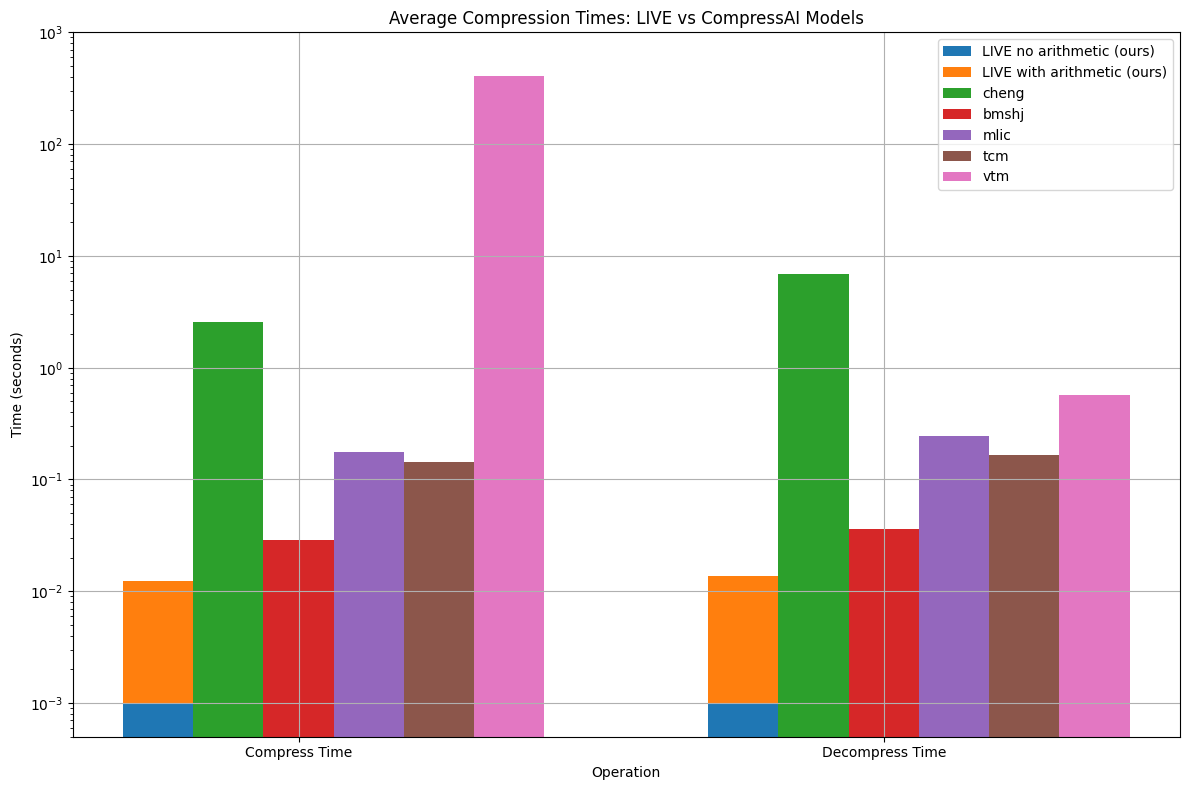

In [49]:
# Calculate average compression and decompression times for neural network models
compress_times = {image_type: [] for image_type in ['cheng', 'bmshj', 'mlic', 'tcm', 'vtm']}
decompress_times = {image_type: [] for image_type in ['cheng', 'bmshj', 'mlic', 'tcm', 'vtm']}

for image_type in ['cheng', 'bmshj', 'mlic']:
      for quality in compressai_qualities:
            compress_times[image_type].append(average_metrics['compression_time'][image_type][quality])
            decompress_times[image_type].append(average_metrics['decompression_time'][image_type][quality])

for quality in TCM_lambdas:
      compress_times['tcm'].append(average_metrics['compression_time']['tcm'][quality])
      decompress_times['tcm'].append(average_metrics['decompression_time']['tcm'][quality])

for quality in vtm_qualities:
      compress_times['vtm'].append(average_metrics['compression_time']['vtm'][quality])
      decompress_times['vtm'].append(average_metrics['decompression_time']['vtm'][quality])

avg_compress_time = {image_type: np.mean(compress_times[image_type]) for image_type in ['cheng', 'bmshj', 'mlic', 'tcm', 'vtm']}
avg_decompress_time = {image_type: np.mean(decompress_times[image_type]) for image_type in ['cheng', 'bmshj', 'mlic', 'tcm', 'vtm']}

# Calculate average compression and decompression times for LIVE
compress_times_live = [average_metrics['compression_time']['live'][lambda_val] for lambda_val in lambda_vals]
decompress_times_live = [average_metrics['decompression_time']['live'][lambda_val] for lambda_val in lambda_vals]
no_strings_times_live = [average_metrics['no_strings_time']['live'][lambda_val] for lambda_val in lambda_vals]

avg_compress_time['live'] = np.mean(compress_times_live)
avg_decompress_time['live'] = np.mean(decompress_times_live)
avg_no_strings_time = {'live': np.mean(no_strings_times_live)}

all_avg_compress_times.append(avg_compress_time)

# Create bar chart
labels = ['Compress Time', 'Decompress Time']
x = np.arange(len(labels)) * 1.25
width = 0.15 

fig, ax = plt.subplots(figsize=(12, 8))

# Plot LIVE bars first
ax.bar(x - 2*width, [avg_no_strings_time['live']/2, avg_no_strings_time['live']/2], 
      width, label='LIVE no arithmetic (ours)')
ax.bar(x - 2*width, [avg_compress_time['live'], avg_decompress_time['live']], width,
      bottom=[avg_no_strings_time['live']/2, avg_no_strings_time['live']/2], label='LIVE with arithmetic (ours)')

# Plot neural network model bars
models = ['cheng', 'bmshj', 'mlic', 'tcm', 'vtm']
for i, model in enumerate(models):
    offset = (i - 1) * width
    compress_time = avg_compress_time[model]
    decompress_time = avg_decompress_time[model]
    ax.bar(x + offset, [compress_time, decompress_time], width, label=model)

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_yscale('log')
ax.set_ylim(5e-4, 1e3)
ax.set_title('Average Compression Times: LIVE vs CompressAI Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

In [50]:
import numpy as np
from scipy.interpolate import interp1d

def parse_json_metrics(data):
    """Parse metrics from JSON format with various key formats (int, float, scientific notation)"""
    bpp_values = []
    psnr_values = []
    
    # Convert all keys to float, handling scientific notation
    try:
        # Try sorting keys as floats (handles both regular numbers and scientific notation)
        qualities = sorted(float(q) for q in data.keys())
    except ValueError:
        # If that fails, just use the keys as they are
        qualities = sorted(data.keys())
    
    for quality in qualities:
        # Convert back to string for dictionary lookup
        # For scientific notation, need to handle the original string format
        if isinstance(quality, float):
            # Try to find the original key that matches this float value
            quality_key = [k for k in data.keys() if abs(float(k) - quality) < 1e-10][0]
        else:
            quality_key = str(quality)
            
        images_data = data[quality_key]
        
        # Handle both list of dictionaries and direct metric values
        if isinstance(images_data, list):
            avg_bpp = np.mean([img['bpp'] for img in images_data])
            avg_psnr = np.mean([img['psnr'] for img in images_data])
        else:
            # If it's direct metrics
            avg_bpp = images_data['bpp']
            avg_psnr = images_data['psnr']
        
        bpp_values.append(avg_bpp)
        psnr_values.append(avg_psnr)
    
    return np.array(bpp_values), np.array(psnr_values)

def get_interpolated_psnr(data, target_bpp=0.45):
    """
    Interpolate PSNR values at a specific BPP value.
    
    Args:
        data: Metrics data in any supported format
        target_bpp (float): The BPP value at which to interpolate PSNR
        
    Returns:
        float: Interpolated PSNR value at target_bpp
    """
    bpp_values, psnr_values = parse_json_metrics(data)
    
    # Sort by BPP to ensure proper interpolation
    sort_idx = np.argsort(bpp_values)
    bpp_values = bpp_values[sort_idx]
    psnr_values = psnr_values[sort_idx]
    
    # Check if target_bpp is within range
    if target_bpp < min(bpp_values) or target_bpp > max(bpp_values):
        print(f"Warning: {target_bpp} is outside the available range [{min(bpp_values):.3f}, {max(bpp_values):.3f}] for this model")
        return None
    
    # Create interpolation function and get interpolated value
    interpolator = interp1d(bpp_values, psnr_values, kind='linear')
    return float(interpolator(target_bpp))

# Dictionary to store results
results = {}

# Process each model's data
models_data = {
    'bmshj': metrics['bmshj'],
    'cheng': metrics['cheng'],
    'tcm': metrics['tcm'],
    'mlic': metrics['mlic'],
    'vtm': metrics['vtm'],
    'webp': metrics['webp'],
    'jpeg': metrics['jpeg'],
    'avif': metrics['avif'],
    'heif': metrics['heif'],
    'live': metrics['live']
}

# Print results
print(f"\nInterpolated PSNR values at BPP = 0.45:")
for model_name, data in models_data.items():
    interpolated_psnr = get_interpolated_psnr(data, target_bpp=0.45)
    if interpolated_psnr is not None:
        results[model_name] = interpolated_psnr
        print(f"{model_name}: PSNR = {interpolated_psnr:.2f} dB")



Interpolated PSNR values at BPP = 0.45:
bmshj: PSNR = 31.52 dB
cheng: PSNR = 33.87 dB
tcm: PSNR = 34.31 dB
mlic: PSNR = 34.73 dB
vtm: PSNR = 33.80 dB
webp: PSNR = 32.03 dB
jpeg: PSNR = 29.65 dB
avif: PSNR = 33.23 dB
heif: PSNR = 33.16 dB
live: PSNR = 37.37 dB


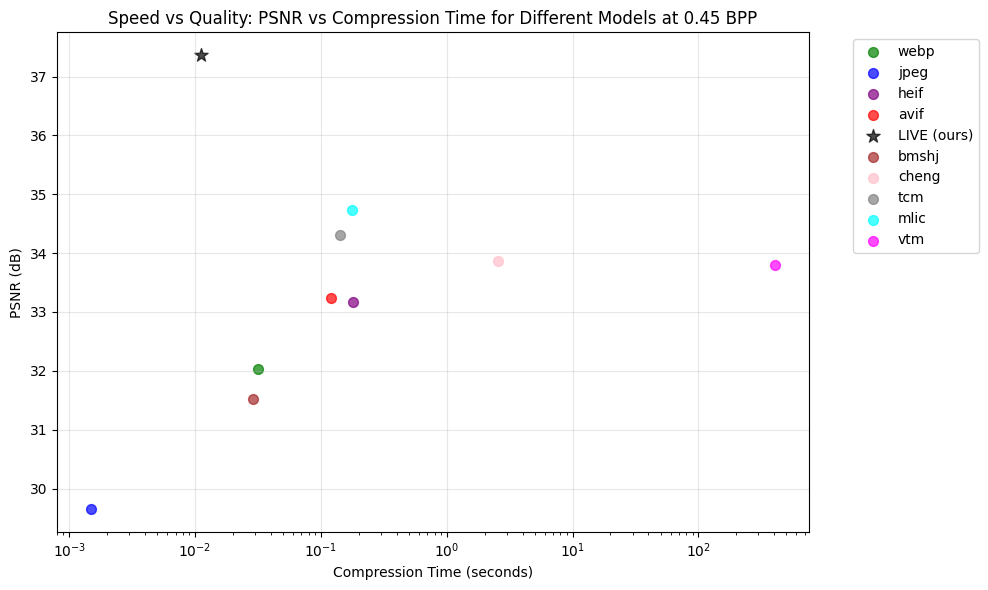

In [51]:
# Create scatter plot of PSNR vs Compression Time at BPP = 0.45
plt.figure(figsize=(10, 6))

# Define colors for different models
model_colors = {
    'jpeg': 'blue',
    'webp': 'green', 
    'avif': 'red',
    'heif': 'purple',
    'bmshj': 'brown',
    'cheng': 'pink',
    'tcm': 'gray',
    'mlic': 'cyan',
    'vtm': 'magenta',
    'live': 'black'
}

# Define markers for different models
model_markers = {
    'live': '*',  # Star marker for LIVE
    'jpeg': 'o',
    'webp': 'o',
    'avif': 'o', 
    'heif': 'o',
    'bmshj': 'o',
    'cheng': 'o',
    'tcm': 'o',
    'mlic': 'o',
    'vtm': 'o'
}

# Plot points for each model
for model in average_metrics['psnr'].keys():
    psnr_values = []
    comp_times = []
    psnr_values.append(results[model])
    if model in ["jpeg", "webp", "avif", "heif"]:
        comp_times.append(all_avg_compress_times[0][model])
    else:
        comp_times.append(all_avg_compress_times[1][model])
    
    # Change label for 'live' to 'LIVE (ours)'
    label = 'LIVE (ours)' if model == 'live' else model
    
    plt.scatter(comp_times, psnr_values,  # Switched x and y here
               label=label,
               color=model_colors[model],
               marker=model_markers[model],
               s=100 if model == 'live' else 50,  # Make LIVE marker larger
               alpha=0.7)

plt.xlabel('Compression Time (seconds)')
plt.xscale('log')  # Changed from yscale to xscale
plt.ylabel('PSNR (dB)')  # Switched labels
plt.title('Speed vs Quality: PSNR vs Compression Time for Different Models at 0.45 BPP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

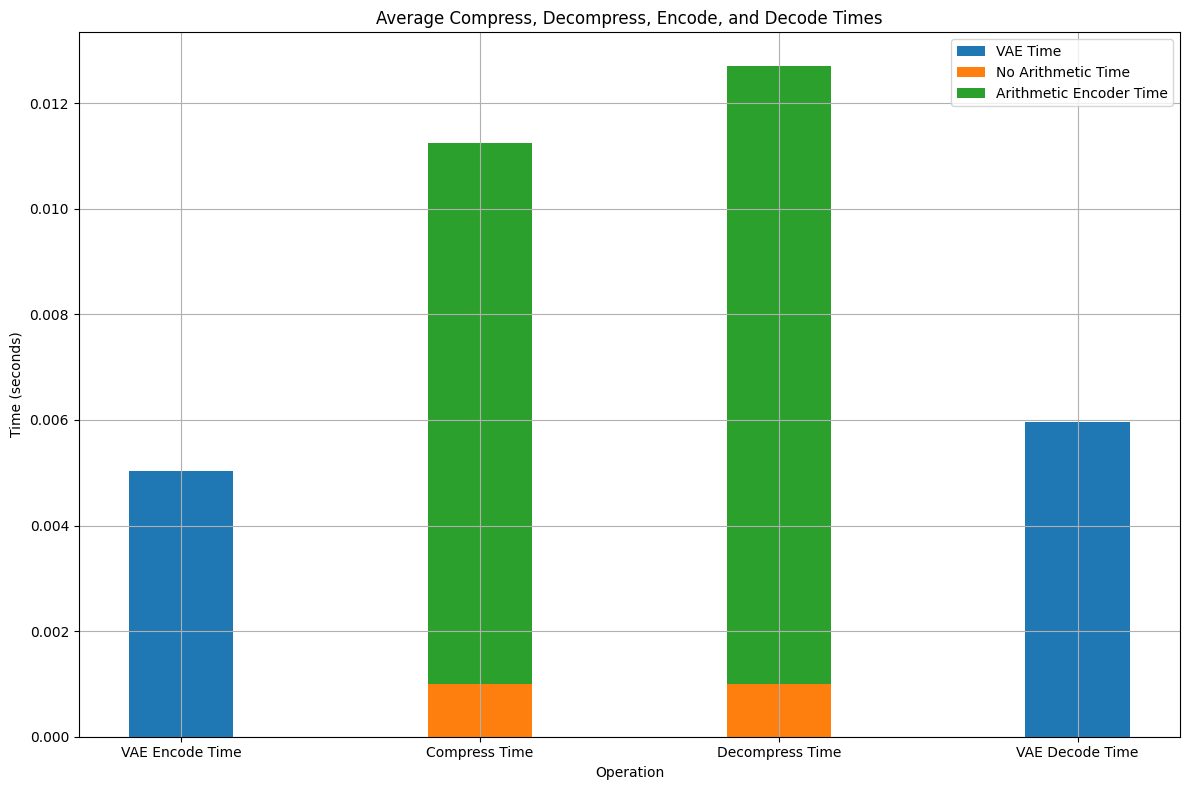

In [52]:
# Create a bar plot that has 'live' compress and decompress time as well as average encode and decode time
labels = ['VAE Encode Time', 'Compress Time', 'Decompress Time', 'VAE Decode Time']
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for 'live' times
compress_time_live = avg_compress_time['live']
compress_strings_time = compress_time_live - avg_no_strings_time['live']/2
decompress_time_live = avg_decompress_time['live']
decompress_strings_time = decompress_time_live - avg_no_strings_time['live']/2
ax.bar(x, [average_encode_time, 0, 0, average_decode_time], width, align='center', label='VAE Time')
ax.bar(x, [0, avg_no_strings_time['live']/2, avg_no_strings_time['live']/2, 0], width, align='center', label='No Arithmetic Time')
ax.bar(x, [0, compress_strings_time, decompress_strings_time, 0  ], width, bottom=[0, avg_no_strings_time['live']/2, avg_no_strings_time['live']/2, 0], align='center', label='Arithmetic Encoder Time')

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Compress, Decompress, Encode, and Decode Times')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()